<a href="https://www.kaggle.com/code/ceecreative/predicting-loan-payback?scriptVersionId=283627644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')

## My Goal:
- Predict the probability that a borrower will pay back their loan.
- Target column - `loan_paid_back`

I will train basline model with all features. After which, I will check whoch features performed the best, then i will consider carrying out further engineering on my features and then tuning my model parameters

# 1. DATA WRANGLING

This stage, we will answer the following questions:
1. is our dataset dirty?
2. is our dataset unstructured?

After cleaning the data (if need be), I will then go further to answer some questions from my data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


after exploring my dataset, i can see that there is no missing values and the dataset looks tidy. let's go further to answer some questions

1. is there any relationship between annual income and the ability to pay back loans?
2. Which gender is more likely to pay back their loan?
3. does the amount of loan collected affect the ability to pay back loan?

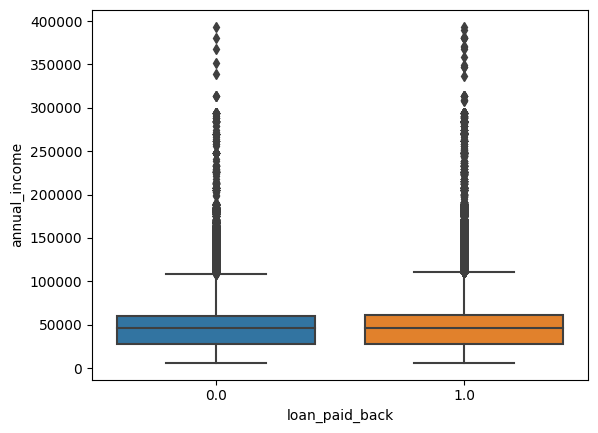

In [4]:
#1.is there any relationship between annual income and the ability to pay back loans?

sb.boxplot(data = df, x = 'loan_paid_back', y = 'annual_income');

Let's interprete the boxplot:

### Group 0 ( didnt pay back loan)
- Average income collected (Median) = usd 50,000
- Most people that did not pay back have annual income usd 15,000 - 75,000
- there is also presence of lots of outliers. some people with annual incomes as high as 120,000 - 400,000 still didnt pay back

after observing Group 1 (people who paid their loans back), the plots look very similar, i tehrefore cant see any relationship between annual income and ability to pay back loan.


In [5]:
pay_loan = df[df['loan_paid_back'] == 1]
gender_count = pay_loan['gender'].value_counts(normalize = True)

In [6]:
gender_index = gender_count.index.tolist()
gender_values = gender_count.values.tolist()

In [7]:
from matplotlib.patches import ConnectionPatch

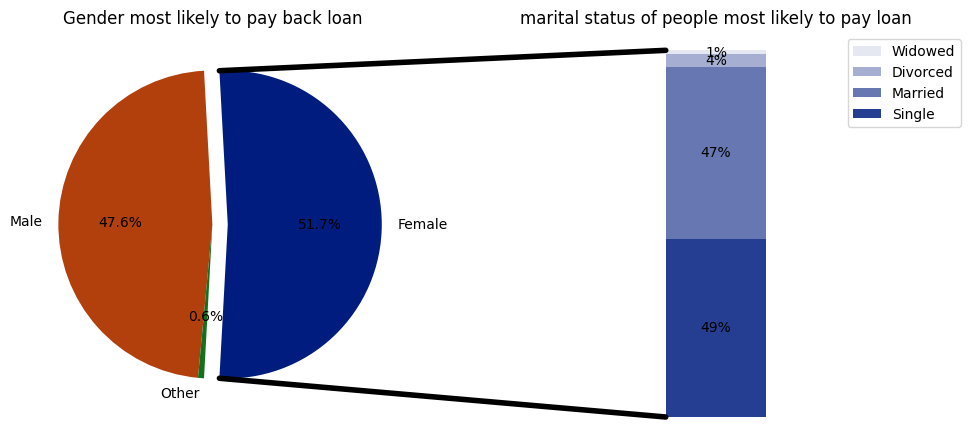

In [8]:
# 2. Which gender is more likely to pay back their loan?

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.subplots_adjust(wspace=0)


#pie parameters
angle = -180 * gender_count.reset_index()['proportion'][0]
explode = [0.1, 0, 0]
colors = sb.color_palette('dark')
wedges, *_ = ax1.pie(
                    gender_count.reset_index()['proportion'],
                    labels=gender_count.reset_index()['gender'],
                    autopct='%1.1f%%',
                    colors = colors,
                    startangle=angle,
                    explode = explode
                    )
ax1.set_title('Gender most likely to pay back loan');

## marital status of the gender most likely to pay back loan
#barchart
f_pay_loan = df[(df['loan_paid_back'] == 1) & (df['gender'] == 'Female')]
marital_count = f_pay_loan['marital_status'].value_counts(normalize = True)
marital_index = marital_count.index.tolist()
marital_values = marital_count.values.tolist()
bottom = 1
width = 0.2

for j, (height, label) in enumerate(reversed([*zip(marital_values, marital_index)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color=colors, label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('marital status of people most likely to pay loan')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(-2.5 * width, 2.5 * width)


# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2 
center, r = wedges[0].center, wedges[0].r
bar_height = sum(marital_values)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

In [9]:
#does the amount of loan collected affect the ability to pay back loan?
df[['loan_amount','loan_paid_back']].corr()

,loan_amount,loan_paid_back
loan_amount,1.000000,-0.003762
loan_paid_back,-0.003762,1.000000


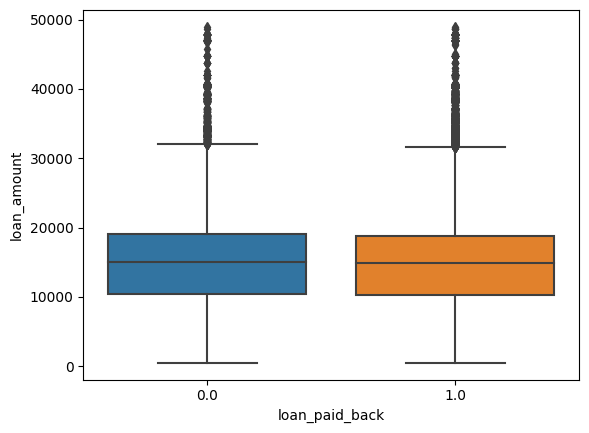

In [10]:
sb.boxplot(data = df, y = 'loan_amount', x = 'loan_paid_back');

# 2. FEATURE ENGINEERING

In [11]:
df['loan_paid_back'].value_counts()

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

There are so many ways to handle class imbalance (as you can see in the article in the resource section, However, I will be using the resample method

In [12]:
from sklearn.utils import resample

In [13]:
def resample_label(df):

    #divide minnority and majority class
    df_major = df[df['loan_paid_back'] == 1]
    df_minor = df[df['loan_paid_back'] == 0]

    # Upsampling minority class
    df_minor_sample = resample(df_minor,
                           
                           # Upsample with replacement
                           replace=True,    

                           # Number to match majority class
                           n_samples=295000,   #i chose a number somewhere in the middle  
                           random_state=42)

    # Upsampling minority class
    df_major_sample = resample(df_major,
                           
                           # downsample with replacement
                           replace=False,    

                           # Number to match majority class
                           n_samples=295000,   #i chose a number somewhere in the middle  
                           random_state=42)

    #join two dataframe
    df_resampled = pd.concat([df_major_sample,df_minor_sample])
    df_resampled = df_resampled.reset_index(drop=True)

    return df_resampled

In [14]:
df_resampled = resample_label(df)

In [15]:
df_resampled = df_resampled.drop(['id','grade_subgrade','loan_purpose'],axis = 1)

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
def one_hot_encode(df):
    object_df = df.select_dtypes(include='object')
    encoders = {}
    encoded_parts = []

    for col in object_df.columns:
        # find most frequent category
        most_freq = df[col].value_counts().idxmax()

        # force category order so "most_freq" comes first
        cat_order = [most_freq] + [c for c in df[col].unique() if c != most_freq]

        encoder = OneHotEncoder(
            handle_unknown='ignore',
            drop='first',
            categories=[cat_order],
            sparse_output=False
        )

        arr = encoder.fit_transform(df[[col]])

        encoded_df = pd.DataFrame(
            arr,
            columns=encoder.get_feature_names_out([col]),
            index=df.index
        )

        encoded_parts.append(encoded_df)

    # drop original objects
    df_ = df.drop(object_df.columns, axis=1)

    # add encoded columns
    df_ = pd.concat([df_] + encoded_parts, axis=1)

    return df_

In [18]:
dummy_df = one_hot_encode(df_resampled)

# 3. MODELLING

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [20]:
def split_data(df):
    X = df.drop('loan_paid_back', axis = 1)
    y = df['loan_paid_back']
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      test_size = 0.2,
                                                      random_state = 42)
    return X, y, X_train, X_val, y_train, y_val
    

In [21]:
X, y, X_train, X_val, y_train, y_val = split_data(dummy_df)

In [22]:
def train_model(X_train, X_val, y_train, y_val,model):

    #fit model
    model.fit(X_train,y_train)

    #predict target column
    y_pred = model.predict(X_val)

    #check accuracy of model
    score = model.score(X_val, y_val)

    return model, y_pred, score

In [23]:
print('xg_accuracy :', train_model(X_train, X_val, y_train, y_val,model = XGBClassifier()))
print('lgbm_accuracy :', train_model(X_train, X_val, y_train, y_val,model = LGBMClassifier()))
print('dt_accuracy :', train_model(X_train, X_val, y_train, y_val,model = DecisionTreeClassifier()))

xg_accuracy : (XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), array([1, 1, 0, ..., 0, 1, 1]), 0.8455423728813559)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 236079, number of negative: 235921
[LightGBM] [Info] Aut

From my analysis, the Decision Tree model performed the best.
I was curious about how feature scaling would affect model accuracy, so I trained the models both with and without scaling.

I observed that scaling significantly improved the performance of linear models, but it had little to no effect on non-linear models such as Decision Trees. This is expected because linear models rely heavily on feature magnitude, while tree-based models split data using thresholds and are generally scale-invariant.

In [24]:
base_model, y_pred, base_score = train_model(X_train, 
                                             X_val, 
                                             y_train, 
                                             y_val, 
                                             model = DecisionTreeClassifier())

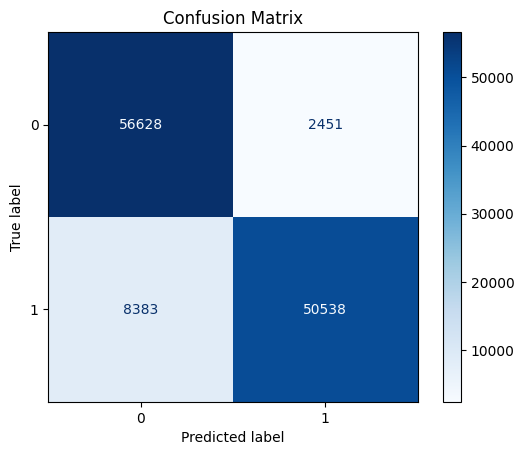

In [25]:
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

I also want to deepen my understanding of feature engineering, because I’ve heard that it’s where most of the work — and most of the performance gains — in machine learning happen.

I’m interested in finding out:

Which features contributed the most to the current model’s performance?

Can any of these important features be engineered into more meaningful or informative versions?

And finally, how much improvement can I get from hyperparameter tuning?
Will the model perform better if I tune the parameters?

Let’s find out.

# 4. MODEL IMPROVEMENT

## Permutation Feature Importance

### 1. Create a function for permutation from scratch

In [26]:
def get_importances(X,y):
    #create dict
    importances = {}

    for feature in X.columns:
        #create copy
        X_perm = X.copy()

        X_perm[feature] = np.random.permutation(X[feature])

        Xp_train, Xp_val, yp_train, yp_val = train_test_split(X_perm, 
                                                              y, test_size = 0.2, 
                                                              random_state = 42)

        #create perm score
        perm_score = base_model.score(Xp_val,yp_val)

        #calculate importance
        importance = base_score - perm_score

        #append to dict
        importances[feature] = importance
        
    #sort by values
    importance_scores = dict(sorted(importances.items(),key=lambda item: item[1]))

    features = list(importance_scores.keys())
    scores = list(importance_scores.values())
        
    return features, scores

In [27]:
features, scores =  get_importances(X,y)

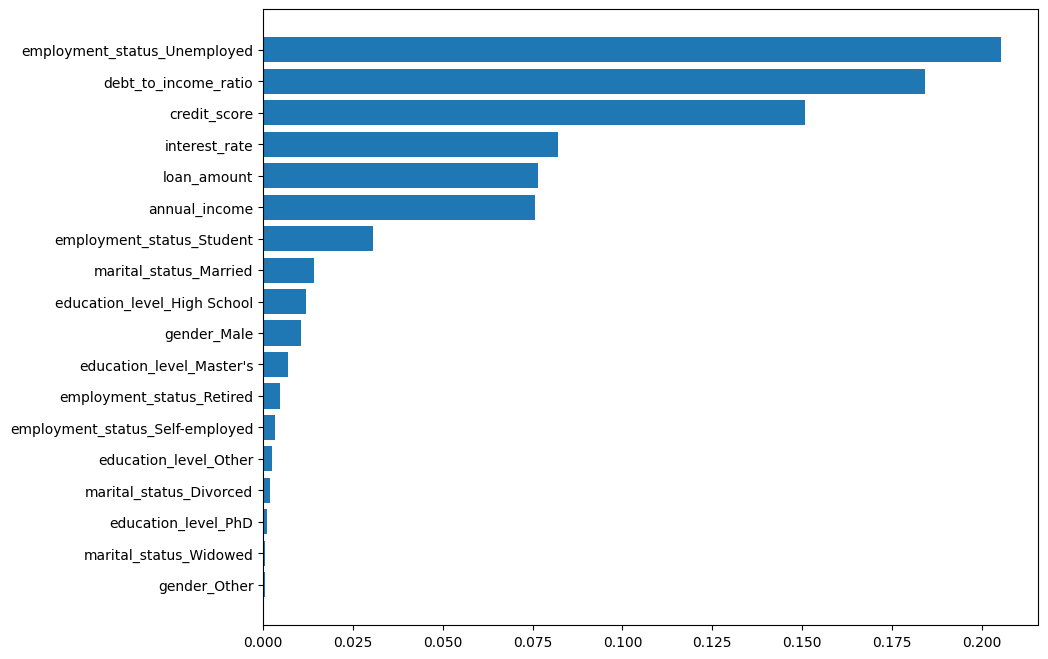

In [28]:
plt.figure(figsize=(10,8))
plt.barh(features,scores);

I also tried using the built-in `model.feature_importances_` attribute, and I noticed that its results were quite similar to what I got from the permutation feature importance method.”

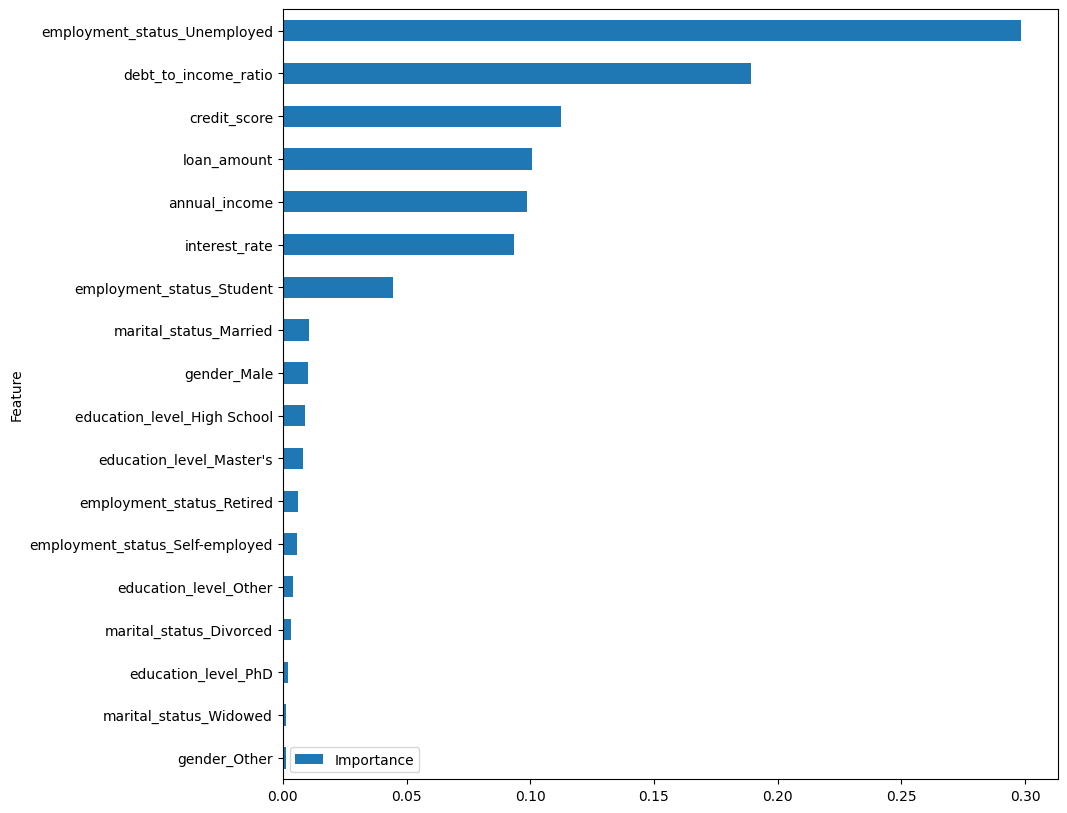

In [29]:
#match importance to feature name

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': base_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

#plot
feature_importances.plot.barh(x='Feature',y='Importance',figsize=(10,10));

### 2. using ELI5 Package

In [30]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [31]:
import eli5

2025-12-03 11:58:20.065515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764763100.285733      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764763100.350674      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [32]:
from eli5.sklearn import PermutationImportance

In [33]:
 # create permutation importance object using model
# and fit on test set
perm = PermutationImportance(base_model, random_state=1).fit(X_val, y_val)

# display weights using PermutationImportance object IN TEXT
print(eli5.format_as_text(eli5.explain_weights(perm, feature_names = X.columns.tolist())))

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.2076 ± 0.0010  employment_status_Unemployed
0.1852 ± 0.0020  debt_to_income_ratio
0.1490 ± 0.0014  credit_score
0.0820 ± 0.0016  interest_rate
0.0750 ± 0.0009  annual_income
0.0743 ± 0.0017  loan_amount
0.0313 ± 0.0006  employment_status_Student
0.0145 ± 0.0003  marital_status_Married
0.0119 ± 0.0008  education_level_High School
0.0103 ± 0.0004  gender_Male
0.0067 ± 0.0004  education_level_Master's
0.0048 ± 0.0003  employment_status_Retired
0.0036 ± 0.0000  employment_status_Self-employed
0.0025 ± 0.0002  education_level_Other
0.0020 ± 0.0002  marital_status_Divorced
0.0010 ± 0.0001  educati

In [34]:
eli5.show_prediction(
                    base_model,
                    X_val.iloc[0],
                    feature_names = X.columns.tolist()
                    )

## ELI5 SHOW_PREDICTION Output (Reinterpreted)

The model is 100% sure this person WILL repay the loan.

Then the contributions:

Contribution	|Feature
----|-----
+0.500|	< BIAS >
+0.157	|credit_score
+0.156	|employment_status_Unemployed
+0.133|	debt_to_income_ratio
+0.025|	employment_status_Student
+0.022|	loan_amount
+0.006|	education_level_Master's
+0.002|	interest_rate
+0.001|	marital_status_Widowed
-0.002|	annual_income

### 🟢 What this means (line-by-line)

#### 1️⃣ <BIAS> = +0.500

This is the biggest insight.

Your model's baseline prediction (before seeing any features) already leans strongly toward:

**👉 predicting loan will be repaid (class 1).**

This suggests:

- Your dataset is imbalanced (more repaid loans than unpaid)

- The model has learned to default to “yes, repay”

This is a common issue in loan datasets.


#### 2️⃣ credit_score (+0.157)

This makes sense.

Higher credit score → more likely to repay → positive contribution.


#### 3️⃣ employment_status_Unemployed (+0.156)

This is a red flag.

The model believes:

**👉 Being unemployed INCREASES the probability of paying loan.**

This is not realistic — it suggests:

#### Possible causes:

- Encoding issue

- Dummy variable trap or collinearity

- Employment categories reversed

- Unemployment is rare in your dataset and those cases repaid

This is a sign of data leakage or skewed correlation.


#### 4️⃣ debt_to_income_ratio (+0.133)

The model believes:

**👉 Higher DTI → MORE likely to repay.**

This is also unrealistic.

It should be:

- High debt → lower ability to repay → NEGATIVE contribution.

This is another red flag.


#### 5️⃣ employment_status_Student (+0.025)

Students slightly more likely to repay?

Could be true depending on your dataset.


#### 6️⃣ loan_amount (+0.022)

Higher loan → more likely to repay — again unusual.

Likely because:

- People who borrow more may have stronger credit history

- Or dataset bias


#### 7️⃣ annual_income (–0.002)

Higher income → slightly reduces probability of repayment.

This is completely the opposite of normal logic.

Another red flag.

### Summary of problems your explanation reveals

Your model is behaving strangely because:

✔ **It is overconfident in predicting repayment**

(`BIAS = +0.500` → always leaning towards 1)

✔ **Several risk features have the WRONG sign**

- Unemployed → more likely to repay

- High DTI → more likely to repay

- Higher loan amount → more likely to repay

- Higher income → slightly LESS likely to repay

This almost always indicates:

#### ⚠️ Data leakage or feature mis-encoding.

#### 🔍 Possible root causes

1️⃣ **Your dataset is imbalanced (many more 1s than 0s)**

Model becomes biased toward predicting repaid.

2️⃣ **Categorical encoding problem**

One-hot encodings may have flipped meaning if you dropped the baseline column.

3️⃣ **Data leakage**

A feature in your dataset indirectly gives away the label.

4️⃣ **Collinearity**

Employment + income + DTI may interact in strange ways.

### Further Feature Engineering

we are going to check if there is any of the following:

- class imbalance
- leaking features
- incorrect encoding
- wrong correlation / collinearity
- model bias

In [35]:
### CHECK CLASS IMBALANCE - DONE ALREADY

### What is data leakage?

Data leakage happens when information from the target (the label you want to predict) accidentally gets into the features during training.
So the model "cheats" by learning patterns it should not have access to in real life.

The model then performs extremely well during training/validation…
but fails badly in the real world.

In [36]:
df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


I don't think any of the features is indirecting revealing the target colummn

#### COLLINEARITY

Are there features that are highly correlated. we will need to drop one

In [37]:
int_df = df_resampled.select_dtypes(exclude = 'object')

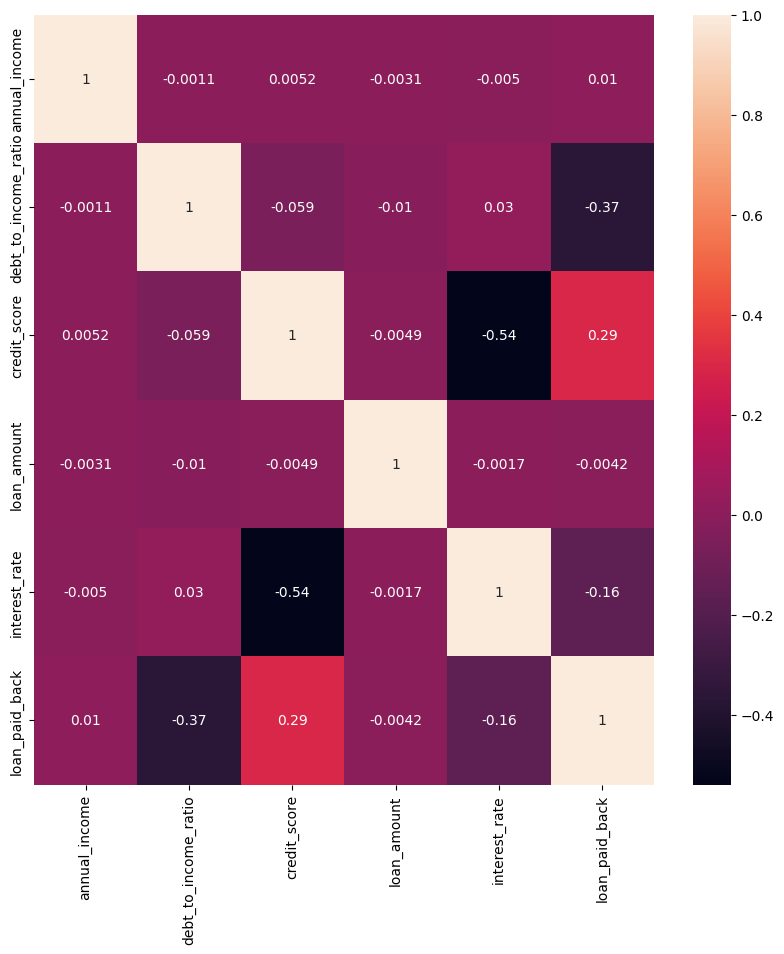

In [38]:
plt.figure(figsize = (10,10))
sb.heatmap(int_df.corr(),annot = True);

I can't notice any feature collinearity

### Feature Engineering

I am going to try creating more features from the features that performed incredibly well

In [76]:
df2 = dummy_df.copy()

In [77]:
df2 = df2.drop(['gender_Male',
          'gender_Other',
         'marital_status_Married',
          'marital_status_Widowed',
          'marital_status_Divorced',
         'education_level_High School',
          "education_level_Master's",
          'education_level_Other',
          'education_level_PhD'],axis=1)

In [78]:
#### AFFORDABILITY INDEX

df2['affordability_index'] = df2['annual_income'] / (df2['debt_to_income_ratio'] * 100)

In [79]:
### TOTAL INTEREST

df2['total_interest'] = df2['loan_amount'] * df2['interest_rate']

In [80]:
### LOAN_INCOME_RATIO

df2['loan_to_income'] = df2['loan_amount'] / df2['annual_income']

In [81]:
### MONTHLY INCOME

df2['monthly_income'] = df2['annual_income'] / 2

In [82]:
### DEBT BURDEN SCORE

df2['debt_burden'] = df2['debt_to_income_ratio'] * df2['loan_to_income']

In [83]:
### RISK FACTOR

df2['risk_factor'] = (1 / df2['credit_score']) * df2['loan_amount']

In [84]:
### Net Available Income

#DTI = total debt payments / income

df2['annual_debt_payment'] = df2['debt_to_income_ratio'] * df2['annual_income']
df2['net_available_income'] = df2['annual_income'] - df2['annual_debt_payment']

In [85]:
### AFFORDABILITY INDEX

df2['AI'] = 1 / df2['debt_to_income_ratio']  ###same as annual income / annual debt payment

# RESOURCES
1. https://seaborn.pydata.org/tutorial/relational.html
2. https://seaborn.pydata.org/tutorial.html
3. https://matplotlib.org/stable/plot_types/index
4. https://www.simplypsychology.org/boxplots.html
5. https://www.geeksforgeeks.org/machine-learning/how-to-handle-imbalanced-classes-in-machine-learning/
6. https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
7. https://builtin.com/data-science/feature-importance
8. https://www.geeksforgeeks.org/machine-learning/machine-learning-explainability-using-permutation-importance/
9. https://www.datacamp.com/blog/data-scientist-interview-questions
10. https://www.geeksforgeeks.org/machine-learning/shap-a-comprehensive-guide-to-shapley-additive-explanations/
11. https://christophm.github.io/interpretable-ml-book/feature-importance.html
12. https://www.youtube.com/watch?v=U-iahfXlSoY
13. https://realpython.com/sort-python-dictionary/
14. https://eli5.readthedocs.io/en/latest/index.html
15. https://www.geeksforgeeks.org/machine-learning/bias-vs-variance-in-machine-learning/
16. https://www.investopedia.com/terms/a/affordability-index.asp